# cTLM analysis script

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
import os
import re

# for bessel functions and curve fitting
from scipy.optimize import curve_fit
from scipy import special

from ipywidgets import interact, fixed
import ipywidgets as widgets
from ipyfilechooser import FileChooser

# plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],  # must be installed on your system
    "mathtext.fontset": "cm",             # Computer Modern math, matches LaTeX style
    "text.usetex": True                    # render text via LaTeX
})

### read files

In [97]:
def clean_inline_data(df):
    # rename columns to identical names from LEB setups
    df = df.rename(columns={'VIN': 'Vin', '-Ch1 IIN': 'Iin', '-Ch1 IOUT': 'Iout', '-Ch2 VINS': 'VinS', '-Ch3 VOUTS -Ch4': 'VoutS'})

    # iterate over all cells to manully remove and handle units + add leading 0
    for col in df.columns:
        for index, val in enumerate(df[col]):
            # scaling factor per row
            multiplier = 1.0
            if 'mA' in val:
                multiplier = 1e-3
            elif 'uA' in val:
                multiplier = 1e-6

            # remove units 
            clean_val = val.replace('V', '').replace('mA', '').replace('uA', '').replace(' ', '')
            # convert unit if needed (mA / uA)
            df[col][index] = float(clean_val) * multiplier

    # convert to float
    df = df.apply(pd.to_numeric, errors='coerce')

    df['delta_V'] = df['VinS'] - df['VoutS']
    return df

In [98]:
folder_path = r"K:\tech_stud\Hager_Lutz\cTLM_Testprozess\IV\cTLM_Ni_final\[processname=cTLM_Ni][structure=CTLM][ri=150][description=Mitte]"

match = re.search(r"\[ri=(\d+)\]", folder_path)
if match:
    r_inner = int(match.group(1))   # or float(...)
    print(r_inner)
else:
    raise ValueError("No r_inner found")

name = os.path.basename(folder_path)
print(name)

list_of_measurements = {}
for file in os.listdir(folder_path):
    if file.endswith('.roh'):
        try:
            data = pd.read_csv(os.path.join(folder_path, file), delimiter='\t', skiprows=12, header=1, encoding='ISO-8859-1')
            data['delta_V'] = data['VinS'] - data['VoutS']
            list_of_measurements[int(os.path.splitext(os.path.basename(file))[0])] = data
      
        except Exception as e:
            pass
        try:
            data = pd.read_csv(os.path.join(folder_path, file), delimiter=r'\s{2,}', skiprows=24, encoding='ISO-8859-1', engine='python')
            data = clean_inline_data(data)

            list_of_measurements[int(os.path.splitext(os.path.basename(file))[0])] = data
        except Exception as e:
            pass

list_of_measurements = dict(sorted(list_of_measurements.items()))
print(list_of_measurements.keys())
# print(list_of_measurements[480])

150
[processname=cTLM_Ni][structure=CTLM][ri=150][description=Mitte]
dict_keys([40, 50, 60, 70, 80, 90, 100, 160, 240, 320, 400, 480])


In [99]:
print(list_of_measurements[40])

      Vin      Iin     Iout   VinS  VoutS  delta_V
0   -1.00 -0.10000  0.10000 -0.062 -0.034   -0.028
1   -0.99 -0.10000  0.10000 -0.062 -0.034   -0.028
2   -0.98 -0.10000  0.10000 -0.062 -0.034   -0.028
3   -0.97 -0.10000  0.10000 -0.062 -0.034   -0.028
4   -0.96 -0.10000  0.10000 -0.062 -0.034   -0.028
..    ...      ...      ...    ...    ...      ...
196  0.96  0.09996 -0.09996  0.063  0.035    0.028
197  0.97  0.09996 -0.09996  0.064  0.035    0.029
198  0.98  0.09996 -0.09996  0.063  0.035    0.028
199  0.99  0.09996 -0.09997  0.063  0.035    0.028
200  1.00  0.09996 -0.09997  0.063  0.035    0.028

[201 rows x 6 columns]


### plot all measurements for a quick overview

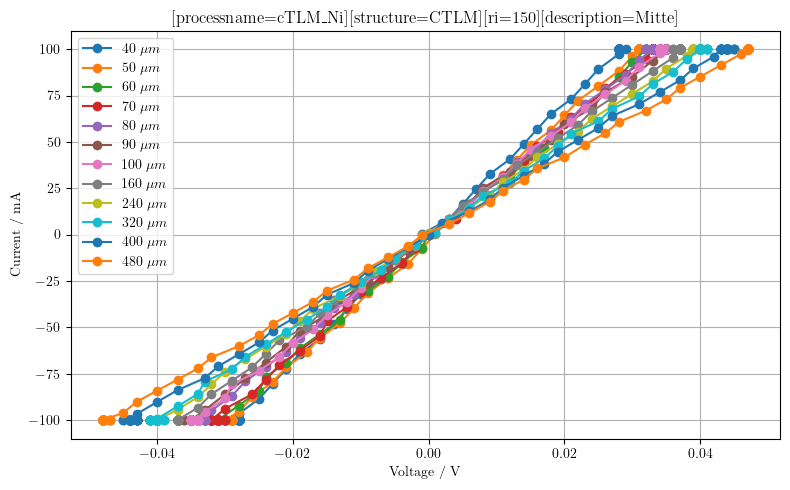

In [100]:
plt.figure(figsize=(8, 5))

for key in list_of_measurements.keys():
    # plt.plot(list_of_measurements[key]['Vin'], list_of_measurements[key]['Iin']*1000, label=key)
    plt.plot(list_of_measurements[key]['delta_V'], list_of_measurements[key]['Iin']*1000, 'o-', label=f"{key} $\\mu m$")

plt.xlabel("Voltage / V")
plt.ylabel("Current / mA")
# plt.xlim(-0.5, 0.5)
plt.title(name)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(folder_path, 'IV.png'), bbox_inches='tight')

In [101]:
def get_lin_fit(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    y_fit = slope * x + intercept
    r_squared = 1- np.sum((y - y_fit)**2)/(np.sum((y - np.mean(y))**2)) # R^2 = 1 - SS_res / SS_tot = 1 - (y-y_fit)^2/(y-mean(y))^2

    return slope, intercept, r_squared

### check lineartiy of individual measuremnts

In [ ]:
def plot_IV(key, plot_data):
    print(key)
    plt.figure(figsize=(8, 5))

    plt.plot(plot_data['delta_V'], plot_data['Iin']*1000, 'o-',label=f"{key} µm")
    slope, intercept, r_squared = get_lin_fit(plot_data['delta_V'], plot_data['Iin'])
    plt.plot(plot_data['delta_V'], (slope * plot_data['delta_V'] + intercept)*1000, 'r--', label=f'linear fit: R² = {r_squared:.3f}')   # *1000 for mA

    plt.xlabel("Voltage / V")
    plt.ylabel("Current / mA")
    plt.title(name)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return    


keys = list(list_of_measurements.keys())
print(keys)
interact(
    lambda key: plot_IV(keys[key], plot_data=list_of_measurements[keys[key]]),
    key=widgets.IntSlider(min=0, max=len(keys)-1, value=0)
)

[40, 50, 60, 70, 80, 90, 100, 160, 240, 320, 400, 480]


interactive(children=(IntSlider(value=0, description='key', max=11), Output()), _dom_classes=('widget-interact…

<function __main__.<lambda>(key)>

### calcualte TLM resistance values

In [103]:
def get_resistance(list_of_measurements, r_inner):
    R_list = []
    R_corr_list = []
    for key in list_of_measurements.keys():
        slope, intercept, r_squared = get_lin_fit(list_of_measurements[key]['delta_V'], list_of_measurements[key]['Iin'])
        R_list.append((1/slope))  # in ohm
        corr_factor = (r_inner / key) * np.log((r_inner + key) / r_inner)
        # print(corr_factor)
        R_corr_list.append((1/slope)* (1/corr_factor))  # in ohm

    return R_list, R_corr_list

# plot TLM using correction factor
$$c_i = \frac{r_i}{d} \cdot \ln\left(\frac{r_i + d}{r_i}\right)$$
=> $R_{T,lin} = \frac{R_{T_circ}}{c_i}$

In [104]:
def get_ctlm_params(slope, intercept, r_inner):
    R_sh = slope * 2 * np.pi * r_inner   # in Ohm/sq
    R_C = intercept / 2 # in Ohm
    
    L_T = intercept / (slope * 2)
    # simple rho_c calculation
    roh_C = (R_sh * (L_T) ** 2) * 1e-8  # 1e-8 to convert from ohm·μm² to ohm·cm²
    
    return R_sh, R_C, L_T, roh_C

In [105]:
def sci_notation_latex(x, precision=2):
    mantissa, exp = f"{x:.{precision}e}".split("e")
    return rf"{mantissa} \cdot 10^{{{int(exp)}}}"

[ 40  50  60  70  80  90 100 160 240 320 400 480]


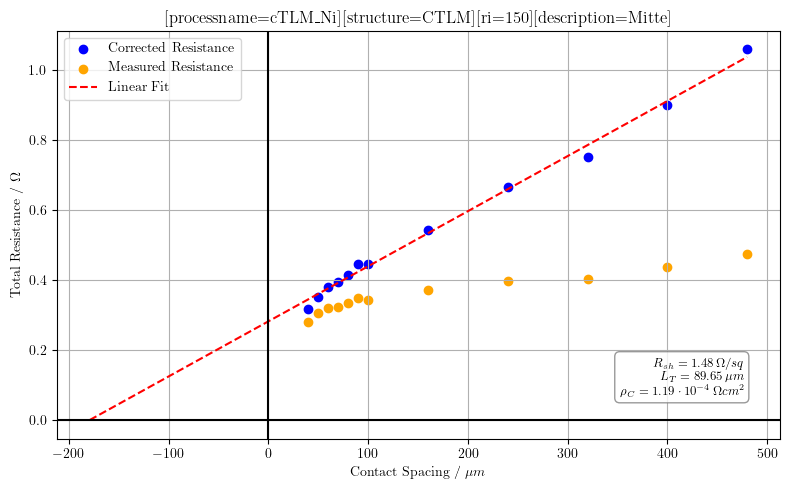

In [106]:
plt.figure(figsize=(8, 5))

distances = list(map(int, list_of_measurements.keys()))
distances = np.array(distances)
print(distances)

R_list, R_corr_list = get_resistance(list_of_measurements, r_inner)  

# plt.scatter(distances, R_corr_list, marker='o', facecolors='none', edgecolors='red', label='Corrected Resistance')
plt.scatter(distances, R_corr_list,  color='blue', marker='o', label='Corrected Resistance')
plt.scatter(distances, R_list, color='orange', marker='o', label='Measured Resistance')

slope, intercept, r_squared = get_lin_fit(distances, R_corr_list)
R_sh, R_C, L_T, roh_C = get_ctlm_params(slope, intercept, r_inner)

x_fit_extended = np.linspace(-intercept/slope, distances.max(), 200) # extend x-axis for better visualization
plt.plot(x_fit_extended, (slope * x_fit_extended + intercept), 'r--', label='Linear Fit')


tlm_text = (
    f"$R_{{sh}} = {R_sh:.2f} \\, \\Omega / sq$\n"
    f"$L_T = {L_T:.2f} \\, \\mu m$\n"
    f"$\\rho_C = {sci_notation_latex(roh_C)} \\, \\Omega cm^2$" # {roh_C:.2e}   {sci_notation_latex(roh_C)}
)

plt.gca().text(
    0.95, 0.1, tlm_text,
    fontsize=9,
    transform=plt.gca().transAxes,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)

plt.title(name)
plt.xlabel("Contact Spacing / $\\mu m$")
plt.ylabel("Total Resistance / $\\Omega$")
plt.legend()
plt.tight_layout()
# plt.xlim(0, max(list_of_measurements.keys())+20)
plt.grid(True)
# plt.savefig(f"Output/{name}_linear.png")
plt.show()

# print('### simple correction model:')
# print(f"Sheet Resistance (R_sh): {R_sh:.4f} Ohms/sq")
# print(f"Contact Resistance (R_C): {R_C:.4f} Ohms")
# print(f"Transfer Length (L_T): {L_T:.4f} μm")
# print(f"Contact Resistivity (rho_C): {roh_C:.2e} Ohm·cm²")

# Using linear approximated fit of $R_T$
$$R_T=\frac{R_{s h}}{2 \pi}\left[\ln \frac{r_i + d}{r_i}+L_T\left(\frac{1}{r_i +d}+\frac{1}{r_i}\right)\right]$$

$$\begin{split}
R_T &= \mathbf{A} \cdot \ln\left(\frac{r_i + d}{r_i}\right) + \mathbf{B} \cdot \left(\frac{1}{r_i + d} + \frac{1}{r_i}\right)\\
&= A \cdot x_1 + B \cdot x_2
\end{split}$$
$$\mathbf{A} = \frac{R_S}{2\pi}$$
$$\mathbf{B} = \frac{R_S L_T}{2\pi}$$

In [107]:
def fit_linear_approximation(distances, R_list, r_inner):

    R_T = R_list.reshape(-1, 1)  # transpose to column vector
    
    # define column vector for X-matrix
    x1 = np.log((r_inner + distances) / r_inner).reshape(-1, 1)
    x2 = (1/(r_inner + distances) + 1/r_inner).reshape(-1, 1)
    
    X = np.hstack((x1, x2))  # shape (n, 2)
    # print('X_matrix=', X)
    
    # use Linear Least Squares fitting to find the vector [A, B]
    A, B = np.linalg.lstsq(X, R_T, rcond=None)[0]
    
    d_fit = np.arange(0, max(distances), 1)
    # define the fitting function
    R_fit = A * np.log((r_inner + d_fit) / r_inner) + B * (1 / (r_inner + d_fit) + 1 / r_inner) # are those the correct radii?
    
    # get sheet resitance in ohms
    R_sh = A * 2 * np.pi

    # get transfer length in μm
    L_T = (2 * np.pi * B) / R_sh
    
    # get contact resistivity in ohm·μm²
    rho_c = (R_sh * (L_T**2)) * 1e-8  # 1e-8 to convert from ohm·μm² to ohm·cm²
    
    # Use intercept of fit
    R_intercept = (B * 2 )/ r_inner
    
    return d_fit, R_fit, R_sh[0], L_T[0], rho_c[0], R_intercept[0]

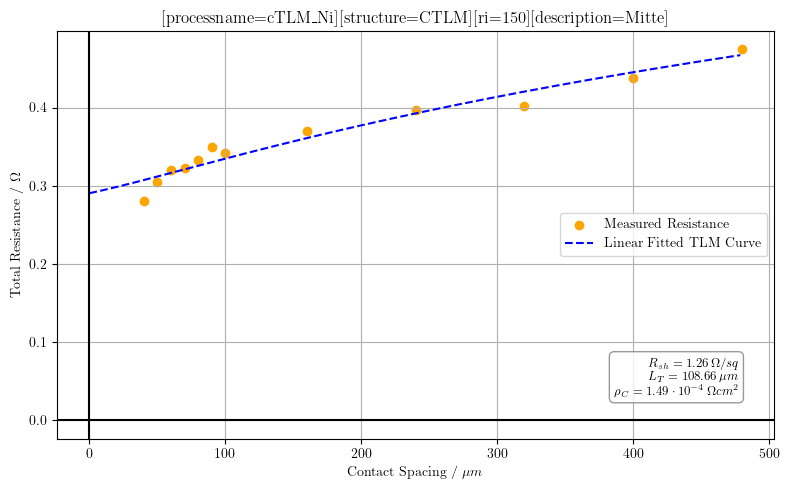

In [108]:
plt.figure(figsize=(8, 5))

distances = list(map(int, list_of_measurements.keys()))
distances = np.array(distances)

R_list, R_corr_list = get_resistance(list_of_measurements, r_inner)  

plt.scatter(distances, R_list, color='orange', marker='o', label='Measured Resistance')

d_fit, R_fit, R_sh_linear, L_T_linear, rho_C_linear, R_intercept = fit_linear_approximation(distances, np.array(R_list), r_inner)

plt.plot(d_fit, R_fit, color='blue', linestyle='--', label='Linear Fitted TLM Curve')


tlm_text = (
    f"$R_{{sh}} = {R_sh_linear:.2f} \\, \\Omega / sq$\n"
    f"$L_T = {L_T_linear:.2f} \\, \\mu m$\n"
    f"$\\rho_C = {sci_notation_latex(rho_C_linear)} \\, \\Omega cm^2$"
)


plt.gca().text(
    0.95, 0.1, tlm_text,
    fontsize=9,
    transform=plt.gca().transAxes,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)

plt.title(name)
plt.xlabel("Contact Spacing / $\\mu m$")
plt.ylabel("Total Resistance / $\\Omega$")
plt.legend()
plt.tight_layout()
# plt.xlim(0, max(list_of_measurements.keys())+20)
plt.grid(True)
plt.show()

# Using the bessel function equation for $R_T$
$$ R_{T, \text { circ }}=\frac{R_{s h}}{2 \pi}\left[\ln \left(\frac{r_i+s}{r_i}\right)+\frac{L_t}{r_i} \frac{I_0\left(\frac{r_i}{L_t}\right)}{I_1\left(\frac{r_i}{L_t}\right)}+\frac{L_t}{r_i+s} \frac{K_0\left(\frac{r_i+s}{L_t}\right)}{K_1\left(\frac{r_i+s}{L_t}\right)}\right]$$

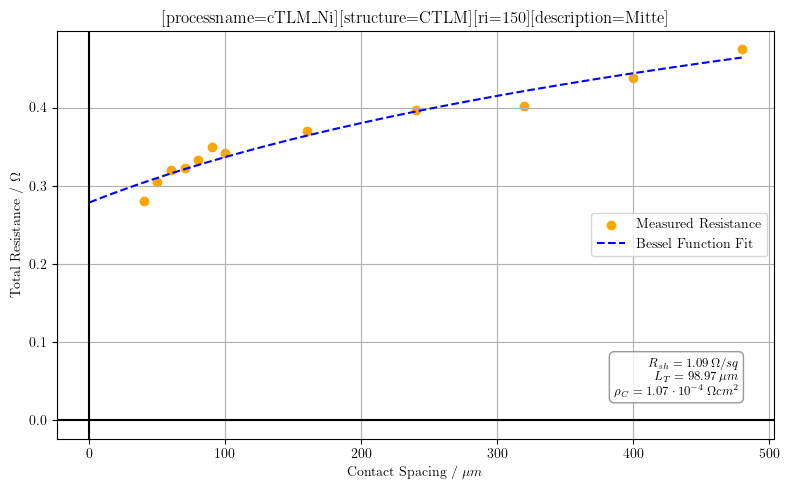

In [109]:
# @param geometries: arrays with the ditances and inner radius of the CTLM structure
# @param Rsh: sheet resistance -> initial guess
# @param Lt: transfer length -> initial guess
# this still uses the assumption of R_sh being constant under and between the contacts
def ctlm_bessel_model(geometries, Rsh, L_T):
        
        (distances, r_inner) = geometries
        # Term 1: Resistance of the semiconductor gap
        term_gap = np.log((r_inner + distances) / r_inner)
        
        # Term 2: Resistance of the inner contact (using using bessel functions I0 and I1)
        term_inner = (L_T / r_inner) * (special.i0(r_inner / L_T) / special.i1(r_inner / L_T))
        
        # Term 3: Resistance of the outer contact (using bessel functions K0 and K1)
        term_outer = (L_T / (r_inner + distances)) * (special.k0((r_inner + distances) / L_T) / special.k1((r_inner + distances) / L_T))
        
        # Total Resistance
        R_T = (Rsh / (2 * np.pi)) * (term_gap + term_inner + term_outer)

        return R_T

# Initial Guess: [Rsh, Lt]
p0 = [R_sh_linear, L_T_linear]
bounds = ([0, 0], [np.inf, np.inf])
r_inner_array = np.full_like(distances, r_inner)

popt, pcov = curve_fit(ctlm_bessel_model, (distances, r_inner_array), R_list, p0=p0, bounds=bounds)

Rsh_fit, Lt_fit = popt

rho_c_fit = Rsh_fit * (Lt_fit**2) * 1e-8  # 1e-8 to convert from ohm·μm² to ohm·cm²

distances_smooth = np.linspace(0, max(distances), 300) # min(distances)
ri_smooth = np.full_like(distances_smooth, r_inner)
Rt_fit_curve = ctlm_bessel_model((distances_smooth, ri_smooth), Rsh_fit, Lt_fit)

plt.figure(figsize=(8, 5))

plt.scatter(distances, R_list, color='orange', marker='o', label='Measured Resistance')
plt.plot(distances_smooth, Rt_fit_curve, color='blue', linestyle='--', label='Bessel Function Fit')

d_fit, R_fit, R_sh_linFit, L_T_linFit, rho_C_linFit, R_intercept = fit_linear_approximation(distances, np.array(R_list), r_inner)
# plt.plot(d_fit, R_fit, color='green', linestyle='--', label='Linear Approximated Fit')

tlm_text = (
    f"$R_{{sh}} = {Rsh_fit:.2f} \\, \\Omega / sq$\n"
    f"$L_T = {Lt_fit:.2f} \\, \\mu m$\n"
    f"$\\rho_C = {sci_notation_latex(rho_c_fit)} \\, \\Omega cm^2$"
)

plt.gca().text(
    0.95, 0.1, tlm_text,
    fontsize=9,
    transform=plt.gca().transAxes,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)

plt.title(name)
plt.xlabel("Contact Spacing / $\\mu m$")
plt.ylabel("Total Resistance / $\\Omega$")
plt.legend()
plt.tight_layout()
# plt.xlim(0, max(list_of_measurements.keys())+20)
plt.grid(True)
# plt.savefig(f'Output/{name}_bessel.png')
plt.show()

In [110]:
# 1. Get the standard deviation (1-sigma error)
# pcov diagonals: [var(Rsh), var(Lt)]
perr = np.sqrt(np.diag(pcov))

# 2. Extract specific errors
Rsh_err = perr[0]
Lt_err = perr[1]

# 3. Calculate 95% Confidence Interval (approx. 1.96 * sigma)
Rsh_ci = 1.96 * Rsh_err
Lt_ci = 1.96 * Lt_err

print(f"Rsh: {Rsh_fit:.3f} +/- {Rsh_ci:.3f} Ohm/sq (95% CI)")
print(f"Lt: {Lt_fit:.3f} +/- {Lt_ci:.3f} um (95% CI)")

Rsh: 1.088 +/- 0.117 Ohm/sq (95% CI)
Lt: 98.965 +/- 10.978 um (95% CI)


In [111]:
# compare results from all models:
results_df = pd.DataFrame(columns=['Value', 'Simple Linear Correction', 'Linear Approximated Model', 'Bessel'])
results_df['Value'] = ['Sheet Resistance (R_sh) [Ohms/sq]', 'Transfer Length (L_T) [μm]', 'Contact Resistivity (rho_C) [Ohm·cm²]']
results_df['Simple Linear Correction'] = [R_sh, L_T, roh_C]
results_df['Linear Approximated Model'] = [R_sh_linear, L_T_linear, rho_C_linear]
results_df['Bessel'] = [Rsh_fit, Lt_fit, rho_c_fit]
results_df

,Value,Simple Linear Correction,Linear Approximated Model,Bessel
0,Sheet Resistance (R_sh) [Ohms/sq],1.482008,1.259728,1.087965
1,Transfer Length (L_T) [μm],89.647431,108.662288,98.965464
2,Contact Resistivity (rho_C) [Ohm·cm²],0.000119,0.000149,0.000107


---
## using a differnt resitance under the contact $R_{sh} \neq R_{sk}$
$$ R_{T, \text { circ }}=\frac{R_{s h} \cdot R_{sk}}{2 \pi}\left[\frac{1}{R_{sk}} \ln \left(\frac{r_i+s}{r_i}\right) + \frac{L_t}{R_{sh} \cdot r_i} \frac{I_0\left(\frac{r_i}{L_t}\right)}{I_1\left(\frac{r_i}{L_t}\right)} + \frac{L_t}{R_{sh} \cdot (r_i+s)} \frac{K_0\left(\frac{r_i+s}{L_t}\right)}{K_1\left(\frac{r_i+s}{L_t}\right)}\right]$$

[np.float64(1.0879654137625), np.float64(1.0879654137625), np.float64(98.96546396419582)]


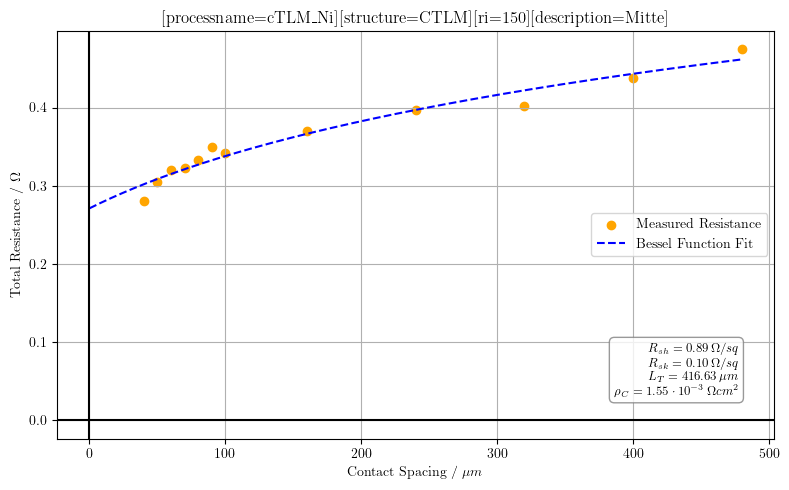

In [112]:
# @param geometries: arrays with the ditances and inner radius of the CTLM structure
# @param Rsh: sheet resistance -> initial guess
# @param Lt: transfer length -> initial guess
# @param Rsk: factor for R_sk
def ctlm_bessel_model_Rsk(geometries, Rsh, Rsk, L_T):

        (distances, r_inner) = geometries
        # Term 1: Resistance of the semiconductor gap
        term_gap = 1/(Rsk) * np.log((r_inner + distances) / r_inner)
        
        # Term 2: Resistance of the inner contact (using using bessel functions I0 and I1)
        term_inner = (L_T / (Rsh * r_inner)) * (special.i0(r_inner / L_T) / special.i1(r_inner / L_T))
        
        # Term 3: Resistance of the outer contact (using bessel functions K0 and K1)
        term_outer = (L_T / (Rsh * (r_inner + distances))) * (special.k0((r_inner + distances) / L_T) / special.k1((r_inner + distances) / L_T))
        
        # Total Resistance
        R_T = ((Rsh * Rsk) / (2 * np.pi)) * (term_gap + term_inner + term_outer)

        return R_T

# Initial Guess: [Rsh, Rsk, Lt]
# p0 = [R_sh_linear, R_sh_linear, L_T_linear]
p0 = [Rsh_fit, Rsh_fit, Lt_fit]
bounds = ([0.1, 0.1, 1], [np.inf, np.inf, np.inf])  # initial guess for R >0 and L_T > 1 => protects from overflow of bessel functions
r_inner_array = np.full_like(distances, r_inner)    # creates list of r_inner to get same input shape
print(p0)

popt_A, pcov_A = curve_fit(ctlm_bessel_model_Rsk, (distances, r_inner_array), R_list, p0=p0, bounds=bounds)

Rsh_fit_Rsk, Rsk_fit_Rsk, Lt_fit_Rsk = popt_A

rho_c_fit_Rsk = Rsh_fit_Rsk * (Lt_fit_Rsk**2) * 1e-8  # 1e-8 to convert from ohm·μm² to ohm·cm²


distances_smooth = np.linspace(0, max(distances), 300) # min(distances)
ri_smooth = np.full_like(distances_smooth, r_inner)
Rt_fit_curve = ctlm_bessel_model_Rsk((distances_smooth, ri_smooth), Rsh_fit_Rsk, Rsk_fit_Rsk, Lt_fit_Rsk)


plt.figure(figsize=(8, 5))

plt.scatter(distances, R_list, color='orange', marker='o', label='Measured Resistance')
plt.plot(distances_smooth, Rt_fit_curve, color='blue', linestyle='--', label='Bessel Function Fit')

d_fit, R_fit, R_sh_linFit, L_T_linFit, rho_C_linFit, R_intercept = fit_linear_approximation(distances, np.array(R_list), r_inner)
# plt.plot(d_fit, R_fit, color='green', linestyle='--', label='Linear Approximated Fit')

tlm_text = (
    f"$R_{{sh}} = {Rsh_fit_Rsk:.2f} \\, \\Omega / sq$\n"
    f"$R_{{sk}} = {Rsk_fit_Rsk:.2f} \\, \\Omega / sq$\n"
    f"$L_T = {Lt_fit_Rsk:.2f} \\, \\mu m$\n"
    f"$\\rho_C = {sci_notation_latex(rho_c_fit_Rsk)} \\, \\Omega cm^2$"
)


plt.gca().text(
    0.95, 0.1, tlm_text,
    fontsize=9,
    transform=plt.gca().transAxes,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)

plt.title(name)
plt.xlabel("Contact Spacing / $\\mu m$")
plt.ylabel("Total Resistance / $\\Omega$")
plt.legend()
plt.tight_layout()
# plt.xlim(0, max(list_of_measurements.keys())+20)
plt.grid(True)
# plt.savefig(f'Output/{name}_bessel.png')
plt.show()

Problem with fitiing R_sk most likely due to strong correlation of R_sk and L_T\
=> Model varries both variables to essentially modify the same parameter of the data (here the y-intercept)\

possible solution:\
use a fixed sheet resisitance for R_sk -> e.g. Known sheet resistance or resistivity of Ni_2Si\
=> fit model and calculate rho_c using this more accurate L_T

In [113]:
# compare results from all models:
results_df = pd.DataFrame(columns=['Value', 'Simple Linear Correction', 'Linear Approximated Model', 'Bessel'])
results_df['Value'] = ['Sheet Resistance (R_sh) [Ohms/sq]', 'Sheet Resistance (R_sk) [Ohms/sq]', 'Transfer Length (L_T) [μm]', 'Contact Resistivity (rho_C) [Ohm·cm²]']
results_df['Simple Linear Correction'] = [R_sh, 0, L_T, roh_C]
results_df['Linear Approximated Model'] = [R_sh_linear, 0, L_T_linear, rho_C_linear]
results_df['Bessel'] = [Rsh_fit, 0, Lt_fit, rho_c_fit]
results_df['Rsk'] = [Rsh_fit_Rsk, Rsk_fit_Rsk, Lt_fit_Rsk, rho_c_fit_Rsk]
results_df

,Value,Simple Linear Correction,Linear Approximated Model,Bessel,Rsk
0,Sheet Resistance (R_sh) [Ohms/sq],1.482008,1.259728,1.087965,0.893789
1,Sheet Resistance (R_sk) [Ohms/sq],0.000000,0.000000,0.000000,0.100000
2,Transfer Length (L_T) [μm],89.647431,108.662288,98.965464,416.631987
3,Contact Resistivity (rho_C) [Ohm·cm²],0.000119,0.000149,0.000107,0.001551
